In [158]:
from moviepy.editor import VideoFileClip
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob

In [159]:
objpoints = []
imgpoints = []

In [160]:
def findCorners(image, nx, ny):
    objp = np.zeros((ny*nx, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if(ret == True):
        objpoints.append(objp)
#         cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
#         plt.imshow(image)
        imgpoints.append(corners)

def camera_calibrate(image_size):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_size, None, None)
    return mtx, dist

def distortion_correction(image, mtx, dist):
    undist = None
    if (mtx is not None):
        undist = cv2.undistort(image, mtx, dist, None, mtx)
    return undist

def warp_transform(undist_image, image_size):
    src = np.float32([
            [580, 460],
            [700, 460],
            [1040, 680],
            [260, 680],])

    dst = np.float32([
            [260, 0],
            [1040, 0],
            [1040, 720],
            [260, 720],
        ])
    M = cv2.getPerspectiveTransform(src, dst)
    invM = cv2.getPerspectiveTransform(dst, src)
    warp = cv2.warpPerspective(undist_image, M, image_size,flags=cv2.INTER_LINEAR)
    return warp, M, invM

def reverse_warp(invM, image, image_size):
    orig_image = cv2.warpPerspective(image, invM, image_size, flags=cv2.INTER_LINEAR)
    return orig_image
    
def sobel_abs(sobelx, sobely, threshold = (20, 100)):
    scaled_sobelx = np.uint8(255*sobelx/np.max(sobelx))
    scaled_sobely = np.uint8(255*sobely/np.max(sobely))
    sobel_sum = scaled_sobelx + 0.2*scaled_sobely
#     abs_sobel = np.absolute(sobel_sum)
    sobel = np.uint8(255*sobel_sum/np.max(sobel_sum))
    binary_sobel = np.zeros_like(sobel_sum)
    binary_sobel[(sobel >= threshold[0]) & (sobel <= threshold[1])] = 1
    return binary_sobel
    
def sobel_magn(sobelx, sobely, threshold = (30, 255)):
    sobel_sum = np.sqrt(sobelx**2 + sobely**2)
    sobel = np.uint8(sobel_sum /(np.max(sobel_sum)/255))
    binary_sobel = np.zeros_like(sobel)
    binary_sobel[(sobel >= threshold[0]) & (sobel <= threshold[1])] = 1
    return binary_sobel

def sobel_direction(sobelx, sobely, threshold = (0.7, 1.2)):
    sobelx = np.absolute(sobelx)
    sobely = np.absolute(sobely)
    sobel_sum = np.arctan2(sobely, sobelx)
    sobel = np.uint8(sobel_sum /(np.max(sobel_sum)/255))
    binary_sobel = np.zeros_like(sobel)
    binary_sobel[(sobel >= threshold[0]) & (sobel <= threshold[1])] = 1
    return binary_sobel

def color_sobel(img):
#     img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    yellow_min = np.array([18,0,100], np.uint8)
    yellow_max = np.array([30,220,255], np.uint8)
    yellow_mask = cv2.inRange(img, yellow_min, yellow_max)
    
    white_min = np.array([0, 210, 0], np.uint8)
    white_max = np.array([255,255,255], np.uint8)
    white_mask = cv2.inRange(img, white_min, white_max)
    
    binary_output = np.zeros_like(white_mask)
    binary_output[((yellow_mask != 0) | (white_mask != 0))] = 1
    return binary_output
    
   
def combine_thresholds(undest_image, sobel_kernel = 9):
    hls = cv2.cvtColor(undest_image, cv2.COLOR_RGB2HLS).astype(np.float)
    
    color_sobelxs = color_sobel(hls)
    
    color_s = hls[:,:,2]
    sobelx = cv2.Sobel(color_s, cv2.CV_64F, 1, 0,ksize = sobel_kernel)
    sobely = cv2.Sobel(color_s, cv2.CV_64F, 0, 1,ksize = sobel_kernel)

#     abs_threshold = sobel_abs(sobelx,sobely)
    mgn_threshold = sobel_magn(sobelx, sobely)
    direction_threshold = sobel_direction(sobelx, sobely)
    
    
    combined_binary = np.zeros_like(color_sobelxs)
    combined_binary[(color_sobelxs == 1)] = 1
    
#     print(color_s.shape)
#     print(mgn_threshold.shape)
#     print(direction_threshold.shape)
#     combined_binary = np.zeros_like(color_sobelxs)
#     print(combined_binary.shape)
#     combined_binary[(color_sobelxs == 1) & (mgn_threshold == 1)] = 1 #((mgn_threshold == 1) | (direction_threshold == 1))
    return combined_binary

def find_lane_draw(binary_warped):
     
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
       # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped,binary_warped,binary_warped)) * 255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
#         cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
#         (0,255,0), 2) 
#         cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
#         (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit,right_fit, left_lane_inds, right_lane_inds

def find(binary_warped, left_fit,right_fit, left_lane_inds, right_lane_inds):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

#     # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit,right_fit

In [161]:
images = glob.glob('./camera_cal/calibration*.jpg')
for orig_image in images:
    image =  mpimg.imread(orig_image)
    findCorners(image, 9, 6)

In [162]:
first_image = True
left_fit_l = None
right_fit_l= None
left_lane_inds_l= None
right_lane_inds_l= None
def pipeline(image):
    global first_image
    global left_fit_l,right_fit_l, left_lane_inds_l, right_lane_inds_l
    image_size = (image.shape[1], image.shape[0])
    mtx, dist = camera_calibrate(image_size)
    undest_image = distortion_correction(image, mtx, dist)
    binary_image = combine_thresholds(undest_image)
    warp, M, invM = warp_transform(binary_image, image_size)
    if first_image is True:
         left_fit_l, right_fit_l, left_lane_inds_l, right_lane_inds_l  = find_lane_draw(warp)
    else:
         left_fit_l, right_fit_l = find(warp, left_fit_l,right_fit_l, left_lane_inds_l, right_lane_inds_l)
    
    first_image = False
    ploty = np.linspace(0, binary_image.shape[0]-1, binary_image.shape[0] )
    left_fitx = left_fit_l[0]*ploty**2 + left_fit_l[1]*ploty + left_fit_l[2]
    right_fitx = right_fit_l[0]*ploty**2 + right_fit_l[1]*ploty + right_fit_l[2]
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    
    warp_zero = np.zeros_like(binary_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, 
                                  ploty])))])
    pts = np.hstack((left_line_window1, left_line_window2))
    cv2.fillPoly(color_warp, np.int_([pts]), (255,255, 0))

    newwarp = reverse_warp(invM, color_warp, image_size)#invM, image, image_size
# #     out_img = np.dstack((orig_img, orig_img, orig_img))*255
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    return result

def detect_lane(image):
    return pipeline(image)

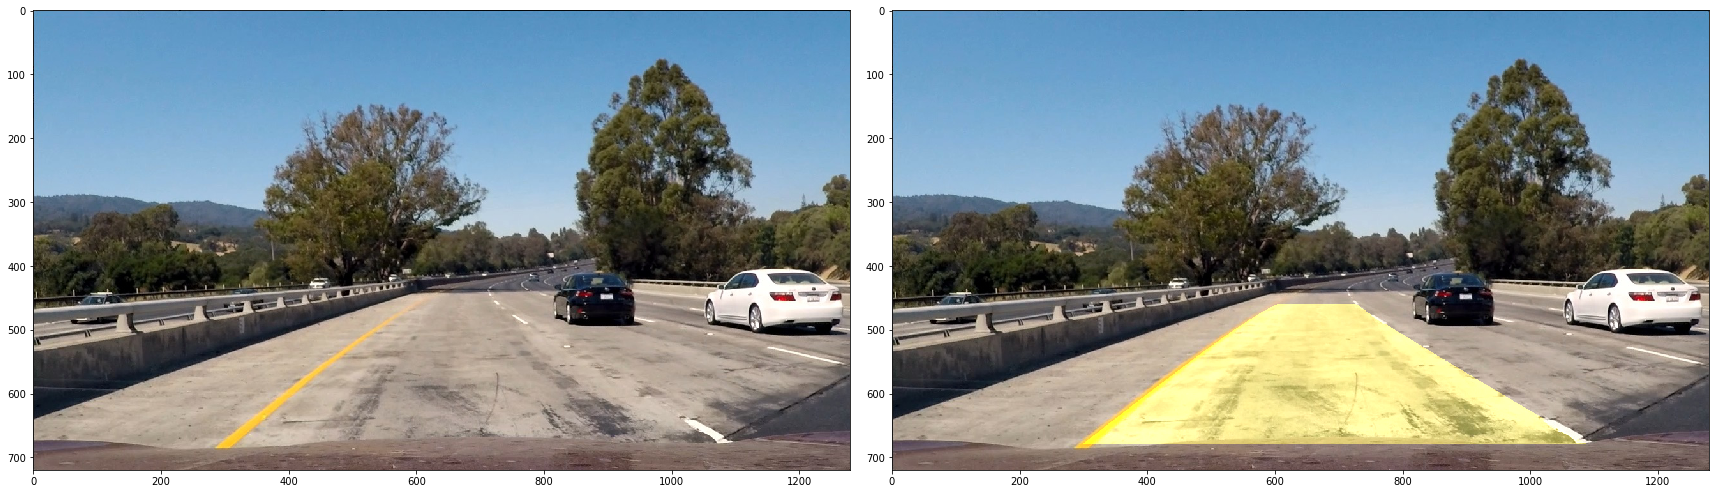

In [156]:
# test_image = './test_images/test1.jpg' #'./camera_cal/calibration1.jpg'
# orig_img =  mpimg.imread(test_image)
# # lane_image = find_lane_draw(warp)
# undest_image = pipeline(orig_img)
# f , (ax1,ax2) = plt.subplots(1,2, figsize=(24,9))
# f.tight_layout()
# ax1.imshow(orig_img)
# ax2.imshow(undest_image)

In [163]:
white_output = 'output_images/project_video.mp4'
video = VideoFileClip('./project_video.mp4')
# clip3 = video.subclip(0,10)
white_clip = video.fl_image(detect_lane)
%time white_clip.write_videofile(white_output, audio=False)

# orig_img = extract_image_for_transform()
# def extract_image_for_transform():
#     clip = video.subclip(0,0)
# #     clip.save_frame('./output_images/lane.jpg',0.0)
# white_clip = clip1.fl_image(process_image)
#     return cv2.imread('./camera_cal/calibration9.jpg')

[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4


100%|█████████▉| 1260/1261 [17:21<00:00,  1.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 

CPU times: user 16min 55s, sys: 1min 3s, total: 17min 59s
Wall time: 17min 22s


In [19]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))